## Reto Data Science
El IBEX 35 es el índice oficial de la bolsa española compuesto por las 35 empresas más negociadas del mercado. Este índice nos muestra en tiempo real si los precios en bolsa están subiendo o bajando, por lo que permite medir el comportamiento de este conjunto de acciones.<br>

El **IBEX35 sirve como punto de referencia para los inversores del mercado español**. La rentabilidad de este índice es el objetivo a batir por los gestores. Por lo tanto, la modelización de las dinámicas de este tipo de índices resultan esenciales **para la toma de decisiones** por parte de todas las entidades bursátiles.

## 1. Librerías necesarias

In [1]:
#-- tratamiento de datos
import pandas as pd
from datetime import datetime
import numpy as np

#-- visualizar datos
import matplotlib.pyplot as plt

#-- escalado de datos (sklearn utilidad)
from sklearn.preprocessing import MinMaxScaler

#--utilidades keras
from keras.preprocessing.sequence import TimeseriesGenerator

from sklearn.metrics import mean_squared_error
from math import sqrt

#--librerias keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

## 2. Lectura/carga de datos

In [2]:
# Dataset de entrenamiento
data = pd.read_csv('train.csv')
data

,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1,1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
2,1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
4,1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1
...,...,...,...,...,...,...,...,...
6549,2019-05-24,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0
6550,2019-05-27,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0
6551,2019-05-28,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0
6552,2019-05-29,9113.200195,9116.700195,9035.099609,9080.500000,9080.500000,148987100.0,0


#### Variables predictoras:

**Date**: Día al que hacen referencia los datos presentados.<br>
**Open**: Precio de apertura de ese día.<br>
**High**: Precio máximo alcanzado durante ese día.<br>
**Low**: Precio mínimo alcanzado durante ese día.<br>
**Close**: Precio de cierre de ese día ajustado por splits.<br>
**Adj Close**: Precio de cierre ajustado por splits y distribuciones de dividendos o plusvalías.<br>
**Volume**: El número físico de acciones negociadas del índice bursátil.<br>

#### Variable objetivo:

**Target**: Esta es la variable a predecir. Es una variable binaria.<br>
**1**: Indica que **el precio de cierre tres días adelante será más alto** que el precio de cierre actual.<br>
**0**: Indica que **el precio de cierre tres días adelante será igual o menor** al precio actual.


In [3]:
# Datos sobre tweets
tweets = pd.read_csv('tweets_from2015_#Ibex35.csv')
tweets

,tweetDate,handle,text
0,Sat Apr 09 14:47:45 +0000 2022,abelac62,He hecho el repaso de todos los componentes de...
1,Thu Apr 07 19:14:36 +0000 2022,LluisPerarnau,Els projectes que han presentat les empreses d...
2,Mon Apr 04 16:48:45 +0000 2022,Pegaso121080,"Por si no lo has visto, o no lo encuentras en ..."
3,Tue Apr 05 07:23:16 +0000 2022,zonavalue,📈 #BOLSA: El #Ibex35 abre en 🟢 \n\n🇪🇸 #Ibex35 ...
4,Thu Mar 31 16:07:43 +0000 2022,EPeconomia,"El #Ibex35 retrocede un 0,4% en marzo y un 3,0..."
...,...,...,...
9796,Thu Jan 08 16:41:36 +0000 2015,elEconomistaes,"#Cierre | El #Ibex35 sube un 2,26% hasta los 1..."
9797,Sat Jan 03 17:20:30 +0000 2015,Roger_bolsa,Un vistazo a los #Bluechips del #Ibex #Ibex35....
9798,Sat Jan 10 19:42:45 +0000 2015,Secretosdebolsa,Así comienza la #Bolsa en #2015 Ojo a los sopo...
9799,Sat Jan 10 21:47:17 +0000 2015,Roger_bolsa,Análisis del #BancoSantander #Santander #SAN t...


Datos con los tweets públicos que contienen el hashtag #Ibex35 desde el año 2015 que han recibido más de dos likes y de dos retweets.

## 3. Preprocesamiento
Análisis, limpieza y transformación de los datos antes de alimentar el algoritmo

**Para los tweets**:

In [4]:
tweets[tweets.isna().values]

,tweetDate,handle,text
1070,Mon Mar 08 07:13:57 +0000 2021,pharma_jonpi,NaN
6931,NaN,NaN,NaN
6931,NaN,NaN,NaN
6931,NaN,NaN,NaN
9634,NaN,NaN,NaN
9634,NaN,NaN,NaN
9634,NaN,NaN,NaN
9667,Y Montoro dando caña....,NaN,NaN
9667,Y Montoro dando caña....,NaN,NaN


Se eliminan esas filas sin valores

In [5]:
tweets = tweets.drop(tweets[tweets.isna().values].index)
tweets = tweets.reset_index(drop=True)

In [6]:
tweets

,tweetDate,handle,text
0,Sat Apr 09 14:47:45 +0000 2022,abelac62,He hecho el repaso de todos los componentes de...
1,Thu Apr 07 19:14:36 +0000 2022,LluisPerarnau,Els projectes que han presentat les empreses d...
2,Mon Apr 04 16:48:45 +0000 2022,Pegaso121080,"Por si no lo has visto, o no lo encuentras en ..."
3,Tue Apr 05 07:23:16 +0000 2022,zonavalue,📈 #BOLSA: El #Ibex35 abre en 🟢 \n\n🇪🇸 #Ibex35 ...
4,Thu Mar 31 16:07:43 +0000 2022,EPeconomia,"El #Ibex35 retrocede un 0,4% en marzo y un 3,0..."
...,...,...,...
9792,Thu Jan 08 16:41:36 +0000 2015,elEconomistaes,"#Cierre | El #Ibex35 sube un 2,26% hasta los 1..."
9793,Sat Jan 03 17:20:30 +0000 2015,Roger_bolsa,Un vistazo a los #Bluechips del #Ibex #Ibex35....
9794,Sat Jan 10 19:42:45 +0000 2015,Secretosdebolsa,Así comienza la #Bolsa en #2015 Ojo a los sopo...
9795,Sat Jan 10 21:47:17 +0000 2015,Roger_bolsa,Análisis del #BancoSantander #Santander #SAN t...


In [7]:
fechas_tweets =[]
c = 0
for i in tweets['tweetDate']:
    try:
        fechas_tweets.append(datetime.strptime(str(i)[0:10] + " " + str(i)[-4:], '%a %b %d %Y'))
    except:
        #se eliminan las filas de estos tweets que no tienen fecha correcta
        print(i)
        tweets = tweets.drop(c)
    c = c +1

#Bolsa #IBEX35 https://t.co/2wBR9k3hHr
https://t.co/XxKoBXa3pC
http://t.co/c0R79uUipa
http://t.co/scHVpKEQ4P http://t.co/uJaCax1Y3H


In [8]:
tweets = tweets.reset_index(drop=True)

In [9]:
tweets

,tweetDate,handle,text
0,Sat Apr 09 14:47:45 +0000 2022,abelac62,He hecho el repaso de todos los componentes de...
1,Thu Apr 07 19:14:36 +0000 2022,LluisPerarnau,Els projectes que han presentat les empreses d...
2,Mon Apr 04 16:48:45 +0000 2022,Pegaso121080,"Por si no lo has visto, o no lo encuentras en ..."
3,Tue Apr 05 07:23:16 +0000 2022,zonavalue,📈 #BOLSA: El #Ibex35 abre en 🟢 \n\n🇪🇸 #Ibex35 ...
4,Thu Mar 31 16:07:43 +0000 2022,EPeconomia,"El #Ibex35 retrocede un 0,4% en marzo y un 3,0..."
...,...,...,...
9788,Thu Jan 08 16:41:36 +0000 2015,elEconomistaes,"#Cierre | El #Ibex35 sube un 2,26% hasta los 1..."
9789,Sat Jan 03 17:20:30 +0000 2015,Roger_bolsa,Un vistazo a los #Bluechips del #Ibex #Ibex35....
9790,Sat Jan 10 19:42:45 +0000 2015,Secretosdebolsa,Así comienza la #Bolsa en #2015 Ojo a los sopo...
9791,Sat Jan 10 21:47:17 +0000 2015,Roger_bolsa,Análisis del #BancoSantander #Santander #SAN t...


Este dataset de tweets quedaría limpio, pero no vamos a utilizarlo para la predicción

**Para el dataset de acciones**:

Analizando los datos vemos que hay filas y columnas vacíos (NaN), analizamos estos valores perdidos:

In [10]:
data[data.isna().values]

,Date,Open,High,Low,Close,Adj Close,Volume,Target
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
3,1994-01-06,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...
5940,2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,0
5940,2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,0
5940,2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,0
5940,2017-01-02,NaN,NaN,NaN,NaN,NaN,NaN,0


Estos registros (filas) sin valores en ninguno de sus campos no proporcionan información. Los eliminamos:

In [11]:
indexes_to_drop = data[data.isna().values].index
indexes_to_drop.unique()

Int64Index([   3,   64,   65,   85,  202,  216,  222,  241,  243,  255,
            ...
            2864, 2869, 2873, 2929, 2930, 3125, 3385, 3637, 4661, 5940],
           dtype='int64', length=133)

133 registros a eliminar

In [12]:
data = data.drop(indexes_to_drop)
data = data.reset_index()

In [13]:
data

,index,Date,Open,High,Low,Close,Adj Close,Volume,Target
0,0,1994-01-03,3615.199951,3654.699951,3581.000000,3654.500000,3654.496338,0.0,0
1,1,1994-01-04,3654.500000,3675.500000,3625.100098,3630.300049,3630.296387,0.0,1
2,2,1994-01-05,3625.199951,3625.199951,3583.399902,3621.199951,3621.196289,0.0,1
3,4,1994-01-07,3621.199951,3644.399902,3598.699951,3636.399902,3636.396240,0.0,1
4,5,1994-01-10,3655.199951,3678.199951,3655.199951,3660.600098,3660.596436,0.0,1
...,...,...,...,...,...,...,...,...,...
6416,6549,2019-05-24,9150.299805,9211.099609,9141.400391,9174.599609,9174.599609,121673100.0,0
6417,6550,2019-05-27,9225.900391,9294.599609,9204.700195,9216.400391,9216.400391,60178000.0,0
6418,6551,2019-05-28,9220.400391,9224.900391,9132.900391,9191.799805,9191.799805,218900800.0,0
6419,6552,2019-05-29,9113.200195,9116.700195,9035.099609,9080.500000,9080.500000,148987100.0,0


Una vez eliminadas las filas con valores perdidos, hemos pasado de 6554 a 6421 registros (133 menos).
Comprobamos si hay algún valor perdido en otras columnas:

In [14]:
data.isna().any()

index        False
Date         False
Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
Target       False
dtype: bool

Analizamos también las correlaciones entre la variable target y las predictoras para ver si existe mayor correlación con alguna de ellas:

In [15]:
data.corr()

,index,Open,High,Low,Close,Adj Close,Volume,Target
index,1.000000,0.504104,0.503450,0.503353,0.503230,0.503231,0.729709,-0.001051
Open,0.504104,1.000000,0.999662,0.999533,0.999187,0.999187,0.134159,-0.017777
High,0.503450,0.999662,1.000000,0.999426,0.999570,0.999570,0.135061,-0.017759
Low,0.503353,0.999533,0.999426,1.000000,0.999632,0.999632,0.131645,-0.017655
Close,0.503230,0.999187,0.999570,0.999632,1.000000,1.000000,0.133103,-0.017414
Adj Close,0.503231,0.999187,0.999570,0.999632,1.000000,1.000000,0.133104,-0.017414
Volume,0.729709,0.134159,0.135061,0.131645,0.133103,0.133104,1.000000,0.000305
Target,-0.001051,-0.017777,-0.017759,-0.017655,-0.017414,-0.017414,0.000305,1.000000


La correlación de las variables 'Open', 'High', 'Low', 'Close' y 'AdjClose' entre sí es muy alta!! Por tanto, no conviene mantener toda esta información, puesto que se daría el problema de **multicolinealidad** que ocurre cuando las variables están correladas.

En su lugar, mantendremos solo una de ellas: 'Close' (precio de cierre), que es el que se quiere predecir si será mayor en 3 días.

Por otro lado, parece que la variable 'Volume' toma valor 0 durante varios años, posiblemente porque no se registraron datos en esas fechas. Por ello vamos a descartarla.

Creamos un dataframe con las features con las que vamos a alimentar al algoritmo. Como hemos visto, vamos a utilizar la variable 'Close'.

In [16]:
features = pd.DataFrame()

**Fecha**

In [17]:
 data['Date']

0       1994-01-03
1       1994-01-04
2       1994-01-05
3       1994-01-07
4       1994-01-10
           ...    
6416    2019-05-24
6417    2019-05-27
6418    2019-05-28
6419    2019-05-29
6420    2019-05-30
Name: Date, Length: 6421, dtype: object

In [18]:
fechas =[]
for i in data['Date']:
    fechas.append(datetime.strptime(str(i), '%Y-%m-%d'))

In [19]:
features['Date'] = fechas

**Precio de cierre**

In [20]:
features['Close'] = data['Close']

**Target**

In [21]:
features['Target'] = data['Target']

In [22]:
features

,Date,Close,Target
0,1994-01-03,3654.500000,0
1,1994-01-04,3630.300049,1
2,1994-01-05,3621.199951,1
3,1994-01-07,3636.399902,1
4,1994-01-10,3660.600098,1
...,...,...,...
6416,2019-05-24,9174.599609,0
6417,2019-05-27,9216.400391,0
6418,2019-05-28,9191.799805,0
6419,2019-05-29,9080.500000,0


In [23]:
features = features.set_index(['Date'])

<AxesSubplot:xlabel='Date'>

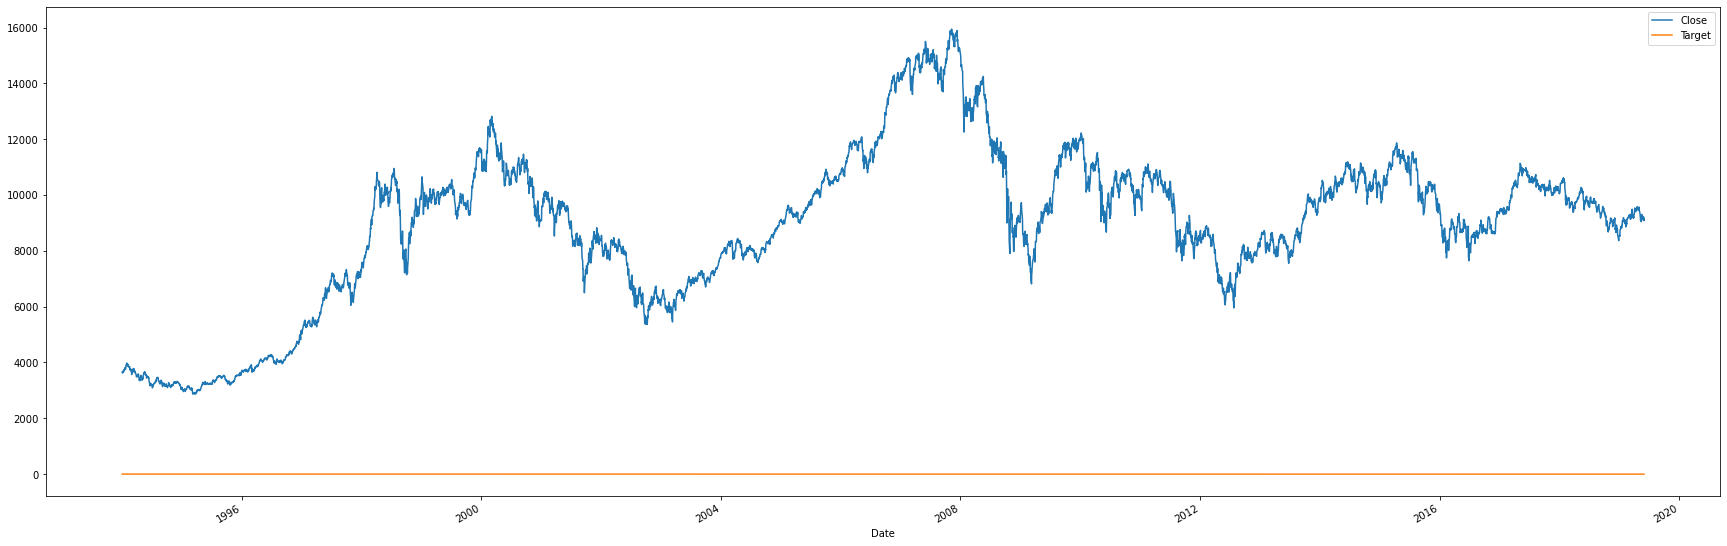

In [24]:
features.plot(figsize=(30, 10))

Parece que el precio de cierre sigue una tendencia (subidas y bajadas) a lo largo del tiempo. Lo podríamos comprobar si no hubiera saltos en las fechas (con seasonal_decompose).

#### Conjuntos de Train y Validation
El conjunto de validación nos servirá para ver cómo de bien predice el modelo. Por eso, separamos los datos en conjunto de entrenamiento (70%) y de validación (30%):

In [25]:
0.7*len(features)

4494.7

In [26]:
train = features[0:4495]
validation = features[4496:]

Escalamos la variable antes de introducirla en el algoritmo (rango 0-1):

In [27]:
scaler = MinMaxScaler()
scaler.fit(train)
X_train = scaler.transform(train)
X_validation = scaler.transform(validation)

In [28]:
# se define el generator
# input = 3 indica que se utilizan datos de 3 días anteriores para predecir el siguiente valor
n_input = 3
# 2 variables de entrada: close y target
n_features = 2
generator = TimeseriesGenerator(X_train, X_train, length=n_input, batch_size=1)

## 4. Algoritmo


Vamos a utilizar [LSTM](http://colah.github.io/posts/2015-08-Understanding-LSTMs/), una red neuronal recurrente que tiene la capacidad de recordar información/eventos pasados y utilizarlos para predecir valores futuros. 

In [29]:
model = Sequential()
#100 neuronas y función de activación RELU
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
#capa de salida (tipo dense)
model.add(Dense(1))
# error cuadrático medio como función de pérdida
model.compile(optimizer='adam', loss='mse')

2022-05-28 20:30:19.427154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


La función de pérdida (o loss function) sirve para evaluar la desviación entre las predicciones realizadas por la red neuronal y los valores reales de las observaciones utilizadas durante el aprendizaje. Cuanto menor es el resultado de esta función, más eficiente es la red neuronal. Su minimización, es decir, reducir al mínimo la desviación entre el valor predicho y el valor real para una observación dada, se hace ajustando los distintos pesos de la red neuronal.

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               41200     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 41,301
Trainable params: 41,301
Non-trainable params: 0
_________________________________________________________________


In [31]:
# fit model
model.fit(generator,epochs=100)

Epoch 1/100
4492/4492 [==============================] - 15s 3ms/step - loss: 0.1317
Epoch 2/100
4492/4492 [==============================] - 15s 3ms/step - loss: 0.1287
Epoch 3/100
4492/4492 [==============================] - 15s 3ms/step - loss: 0.1287
Epoch 4/100
4492/4492 [==============================] - 13s 3ms/step - loss: 0.1286
Epoch 5/100
4492/4492 [==============================] - 10s 2ms/step - loss: 0.1284
Epoch 6/100
4492/4492 [==============================] - 13s 3ms/step - loss: 0.1285
Epoch 7/100
4492/4492 [==============================] - 12s 3ms/step - loss: 0.1282
Epoch 8/100
4492/4492 [==============================] - 13s 3ms/step - loss: 0.1284
Epoch 9/100
4492/4492 [==============================] - 13s 3ms/step - loss: 0.1283
Epoch 10/100
4492/4492 [==============================] - 14s 3ms/step - loss: 0.1284
Epoch 11/100
4492/4492 [==============================] - 15s 3ms/step - loss: 0.1281
Epoch 12/100
4492/4492 [==============================] - 18s 4

4492/4492 [==============================] - 21s 5ms/step - loss: 0.1276
Epoch 97/100
4492/4492 [==============================] - 18s 4ms/step - loss: 0.1276
Epoch 98/100
4492/4492 [==============================] - 18s 4ms/step - loss: 0.1276
Epoch 99/100
4492/4492 [==============================] - 19s 4ms/step - loss: 0.1276
Epoch 100/100
4492/4492 [==============================] - 18s 4ms/step - loss: 0.1275


Graficamos la evolución de la función de pérdida (loss), para comprobar que el número de "epochs" es suficiente (lo será si se produce un descenso en la función de pérdida)

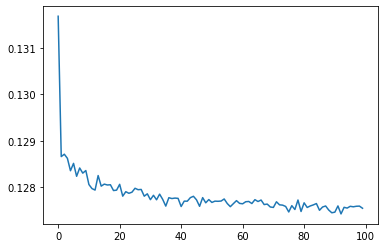

In [32]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

Ahora predecimos los valores de 'target' sobre el conjunto de test:

In [33]:
test_predictions = []

first_eval_batch = X_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(X_validation)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],np.array([[[X_validation[i][0], current_pred[0]]]]),axis=1)

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 21ms/step


In [34]:
#test_predictions contiene las predicciones escaldas!
test_predictions

[array([0.33121297], dtype=float32),
 array([0.40424168], dtype=float32),
 array([0.4763028], dtype=float32),
 array([0.4825707], dtype=float32),
 array([0.48011696], dtype=float32),
 array([0.47923735], dtype=float32),
 array([0.46823484], dtype=float32),
 array([0.46132964], dtype=float32),
 array([0.4541152], dtype=float32),
 array([0.4522828], dtype=float32),
 array([0.45351946], dtype=float32),
 array([0.46668154], dtype=float32),
 array([0.47027862], dtype=float32),
 array([0.48250702], dtype=float32),
 array([0.48413134], dtype=float32),
 array([0.48918343], dtype=float32),
 array([0.4955235], dtype=float32),
 array([0.4971255], dtype=float32),
 array([0.49477348], dtype=float32),
 array([0.4873565], dtype=float32),
 array([0.49254024], dtype=float32),
 array([0.48405182], dtype=float32),
 array([0.48018816], dtype=float32),
 array([0.47403014], dtype=float32),
 array([0.4753172], dtype=float32),
 array([0.47410664], dtype=float32),
 array([0.47572255], dtype=float32),
 array([0

In [35]:
feature_close = []
for i in range(len(X_validation)):
    feature_close.append([X_validation[i][0],test_predictions[i][0]])

## 5. Evaluación del modelo
Comparamos las predicciones del modelo con las verdaderas

In [36]:
#desecalamos las predicciones para compararlas con las verdaderas
true_predictions = scaler.inverse_transform(feature_close)

In [37]:
prediction = validation.copy()

In [38]:
prediction = prediction.drop(['Close'], axis =1)

In [39]:
prediction['Predicted'] = true_predictions[:,1:]

In [44]:
prediction

,Target,Predicted
Date,,
2011-11-14,0,0.331213
2011-11-15,1,0.404242
2011-11-16,0,0.476303
2011-11-17,0,0.482571
2011-11-18,0,0.480117
...,...,...
2019-05-24,0,0.516381
2019-05-27,0,0.517621
2019-05-28,0,0.519476


In [50]:
prediction[(prediction['Target']==0) & (prediction['Predicted']>0.5)]

,Target,Predicted
Date,,
2011-11-14,0,0.331213
2011-11-16,0,0.476303
2011-11-17,0,0.482571
2011-11-18,0,0.480117
2011-11-21,0,0.479237
...,...,...
2019-05-24,0,0.516381
2019-05-27,0,0.517621
2019-05-28,0,0.519476


<AxesSubplot:xlabel='Date'>

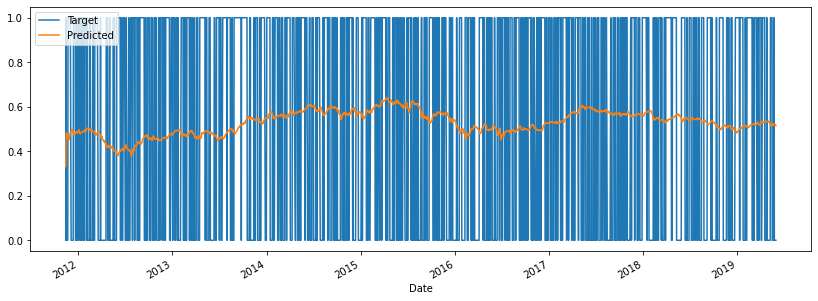

In [40]:
prediction.plot(figsize=(14,5))

In [41]:
rmse=sqrt(mean_squared_error(prediction['Predicted'],prediction['Target']))
print(rmse)

0.5063474247070291


Vemos que el modelo es bastante mejorable, puesto que tiene. una desviación sobre la predicción (0/1) de 0.5.
Podría mejorarse jugando con los hiperparámetros de la red neuronal. Por ejemplo, añadiendo más capas con distinto número de neuronas.

## 6. Exportamos las predicciones

In [78]:
#Importamos el dataset de test:
test = pd.read_csv('test_x.csv', index_col = [0])
test

,Date,Open,High,Low,Close,Adj Close,Volume
test_index,,,,,,,
6557,2019-06-05,9136.799805,9173.400391,9095.000000,9150.500000,9150.500000,158753000.0
6558,2019-06-06,9169.200195,9246.200195,9136.700195,9169.200195,9169.200195,212720900.0
6559,2019-06-07,9186.700195,9261.400391,9185.700195,9236.099609,9236.099609,150664700.0
6560,2019-06-10,9284.200195,9302.200195,9248.099609,9294.099609,9294.099609,102323700.0
6561,2019-06-11,9288.599609,9332.500000,9273.400391,9282.099609,9282.099609,144701200.0
...,...,...,...,...,...,...,...
7278,2022-03-25,8314.099609,8363.200195,8286.500000,8330.599609,8330.599609,156189000.0
7279,2022-03-28,8354.400391,8485.700195,8354.400391,8365.599609,8365.599609,167961800.0
7280,2022-03-29,8451.000000,8621.000000,8419.700195,8614.599609,8614.599609,257812200.0


In [53]:
predictions_test = []

first_eval_batch = X_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    predictions_test.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[[X_validation[i][0], current_pred[0]]]],axis=1)

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - 0s 19ms/step


In [55]:
preds = []
for i in range(len(predictions_test)):
    preds.append(predictions_test[i][0])

In [79]:
fichero_salida = pd.DataFrame(columns = ["test_index","Target"])
fichero_salida["test_index"] = test.index
fichero_salida["Target"] = preds

In [80]:
fichero_salida

,test_index,Target
0,6557,0.331213
1,6558,0.404242
2,6559,0.476303
3,6560,0.482571
4,6561,0.480117
...,...,...
721,7278,0.599202
722,7279,0.596845
723,7280,0.596558
724,7281,0.594694


In [81]:
#Exportamos en csv
fichero_salida.to_csv("predictions.csv", index = False)

In [86]:
fichero_salida = pd.DataFrame(columns = ["Target"], index = test.index)
fichero_salida["Target"] = preds

In [87]:
#Exportamos en json
fichero_salida.to_json("predictions.json", orient='columns')